# Grid Search for Binary Classification

This notebook goes through applying the `GridSearch` algorithm in FairLearn to a binary classification problem, where we also have a binary protected attribute. This algorithm comes from the paper ["A Reductions Approach to Fair Classification" (Agarwal et al. 2018)](https://arxiv.org/abs/1803.02453). The grid search is a simplified version of the full algorithm (appearing in section 3.4), which works best for binary classification and a binary protected attribute.

The specific problem we consider a biased credit scoring problem. We assume that we have a collection of individuals characterised by two features - a credit score in the range $[0, 1]$ and a binary protected attribute from ${a_0, a_1}$. We also have a binary 'score' for each individual indicating whether or not they got a loan. This is determined by applying a threshold to their credit score, and to make the dataset unfair, we can set different thresholds for the two groups $a_0$ and $a_1$.

In this simple case, we make the protected attribute and the credit score available to both the estimator and the model. This gives us a straightforward method of assessing fairness - look at the model, and see if zero weight is put on the protected attribute.

In [1]:
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

We use the following function to create the input data. The credit scores for each population are uniformly distributed in the range $[0, 1]$, and we apply separate thresholds to each subpopulation to determine the score $Y \in {0, 1}$.

In [2]:
def simple_threshold_data(number_a0, number_a1,
                          a0_threshold, a1_threshold,
                          a0_label, a1_label):

    a0s = np.full(number_a0, a0_label)
    a1s = np.full(number_a1, a1_label)

    a0_scores = np.linspace(0, 1, number_a0)
    a1_scores = np.linspace(0, 1, number_a1)
    score_feature = np.concatenate((a0_scores, a1_scores), axis=None)

    A = np.concatenate((a0s, a1s), axis=None)

    Y_a0 = [x > a0_threshold for x in a0_scores]
    Y_a1 = [x > a1_threshold for x in a1_scores]

    Y = np.concatenate((Y_a0, Y_a1), axis=None)

    X = pd.DataFrame({"credit_score_feature": score_feature,
                      "example_sensitive_feature": A})
    return X, Y, A

We now use the above function to generate our dataset. We have 31 individuals with label $a_0$, and they only require a credit score of 0.2 to get the loan. In contrast, the 21 members of the $a_1$ population require a score of 0.7. The label values for $a_0$ and $a_1$ have to be numeric, but the actual values are not especially important. We set them to 2 and 3, to reduce fiddling with `sklearn`.

In [3]:
num_samples_a0 = 31
num_samples_a1 = 21

a0_threshold= 0.2
a1_threshold = 0.7

a0_label = 2
a1_label = 3

X, Y, A = simple_threshold_data(num_samples_a0, num_samples_a1, a0_threshold, a1_threshold, a0_label, a1_label)

The following helper function plots the score $Y$ for each of the subpopulations in our data.

In [4]:
import matplotlib.pyplot as plt
def plot_data(Xs, Ys):
    labels = np.unique(Xs["example_sensitive_feature"])
    
    for l in labels:
        label_string = str(l.item())
        mask = Xs["example_sensitive_feature"] == l
        plt.scatter(Xs[mask].credit_score_feature, Ys[mask], label=str("Label="+label_string))
        plt.xlabel("Credit Score")
        plt.ylabel("Got Loan")
        
    plt.legend()
    plt.show()

Plotting the input data, we can clearly see the bias against the $a_1$ population.

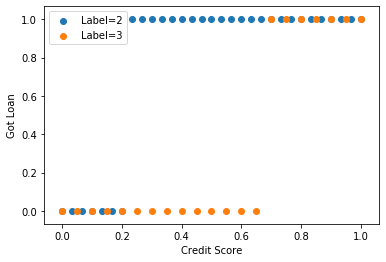

In [5]:
plot_data(X, Y)

For this notebook, we use a simple binary classifier from `sklearn`. We can train this model on our biased data, and look at the weights the model places on each feature. The fact that the `sensitive_features` has non-zero weight (the second entry in the `coef_` array) tells us that we have a biased model (note that measuring fairness in this way is only valid for this simple example notebook - in the real world, fairness is more complicated).

In [6]:
unfair_model = LogisticRegression(solver='liblinear', fit_intercept=True)
unfair_model.fit(X, Y, sample_weight=np.ones(len(Y)))

unfair_model.coef_

array([[ 2.87824386, -0.8620337 ]])

We can also plot out the predictions for this model. We can see that a few points have changed (which is not unexpected) but the bias definitely remains.

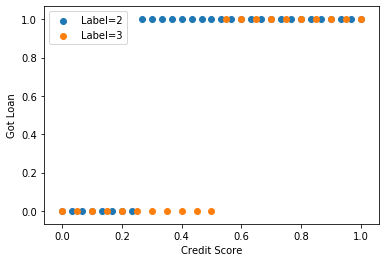

In [7]:
Y_predict_unfair = unfair_model.predict(X)
plot_data(X, Y_predict_unfair)

## Reducing Unfairness with Grid Search

Now, we move on to attempting to reduce the unfairness in our model using the grid search. This tries a series of different models, parameterised by a Lagrange multiplier $\lambda_i$. For each value of $\lambda$, the algorithm reweights and relabels the input data, and trains a fresh model ($\lambda=0$ corresponds to the unaltered case).

The grid search acts like a normal `sklearn` estimator, implementing `fit()` and `predict()` methods. The `fit()` method performs the grid search, and the best model found (according to a specified selection rule) is used in `predict()` calls. However, after `fit()` is called, there are two extra properties on the estimator - a `best_result` and a list `all_results`; the `best_result` is used by `predict()` while `all_results` corresponds to the output of the grid search itself. The items in each are dictionaries, each with four entries - `lambda_vec`, `objective`, `gamma` and `predictor`.

We start by telling the algorithm that we want to try 7 different values of $\lambda$ (which are generated for us).

In [8]:
first_sweep=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                       constraints=DemographicParity(),
                       grid_size=7)

first_sweep.fit(X, Y, sensitive_features=A)

X
    credit_score_feature  example_sensitive_feature
0               0.000000                          2
1               0.033333                          2
2               0.066667                          2
3               0.100000                          2
4               0.133333                          2
5               0.166667                          2
6               0.200000                          2
7               0.233333                          2
8               0.266667                          2
9               0.300000                          2
10              0.333333                          2
11              0.366667                          2
12              0.400000                          2
13              0.433333                          2
14              0.466667                          2
15              0.500000                          2
16              0.533333                          2
17              0.566667                          2
18        

We can examine the values of $\lambda_i$ chosen for us:

In [9]:
lambda_vecs = [x.lambda_vec for x in (first_sweep.all_results)]
lambda_vecs[0]

sign  event  group_id
+     all    2           0.0
             3           0.0
-     all    2           2.0
             3           0.0
Name: 0, dtype: float64

This is rather more than a single value $\lambda$, so what's going on? These results are the outputs of the `Moment` type which drives the reduction approach to removing disparity. There are actually four Lagrange multipliers here, indexed by a tuple (sign, grp, group_id). The 'group_id' field corresponds to the labels $a_0$ and $a_1$, while the 'grp' field is the same in all cases (this is because we have specified Demographic Parity as our disparity criterion). Finally the 'sign' comes from the reductions approach specifying separate multipliers for violations of the disparity criterion from above and below. Both of these are constrained to be positive.

So we have four multipliers - $\lambda_{(+,2)}$, $\lambda_{(-,2)}$, $\lambda_{(+,3)}$ and $\lambda_{(-,3)}$. Without losing generality, we can decide to modify one of these, but not the other, and the `DemographicParity` object we passed to the `GridSearch` constructor chose to make $\lambda_{(+,3)}=\lambda_{(-,3)}=0$. Finally, we can combine the 'above' and 'below' multipliers for the other group and obtain $\lambda_i = \lambda_{(+,2)} - \lambda_{(-,2)}$:

In [10]:
actual_multipliers = [x[("+", "all", 2)]-x[("-", "all", 2)] for x in lambda_vecs]
actual_multipliers

[-2.0,
 -1.3333333333333333,
 -0.6666666666666666,
 0.0,
 0.6666666666666666,
 1.3333333333333333,
 2.0]

And we can look at how the weight the models place on the protected attribute (recall that in the fair case, this would be zero) varies with $\lambda_i$

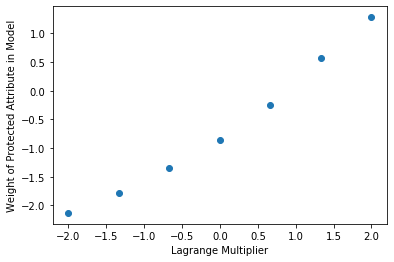

In [11]:
first_sweep_sensitive_feature_weights = [
            x.predictor.coef_[0][1] for x in first_sweep.all_results]
plt.scatter(actual_multipliers, first_sweep_sensitive_feature_weights)
plt.xlabel("Lagrange Multiplier")
plt.ylabel("Weight of Protected Attribute in Model")
plt.show()

We can take a look at the $\lambda$ of the best model found in this sweep, along with the coefficients applied to the features. The weight on the protected attribute is now smaller:

In [12]:
lambda_best = first_sweep.best_result.lambda_vec[("+", "all", 2)]-first_sweep.best_result.lambda_vec[("-", "all", 2)]
print("lambda_best =",lambda_best)
print("coefficients =",first_sweep.best_result.predictor.coef_)

lambda_best = 0.6666666666666666
coefficients = [[ 2.67140771 -0.24157787]]


We can also generate predictions from this model. When we plot them, we see that we're much closer to having a fair model, with the two thresholds closer.

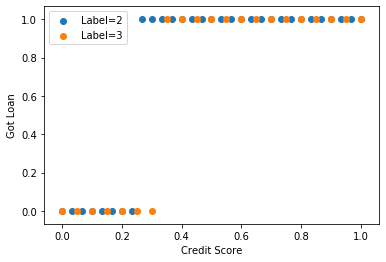

In [13]:
Y_first_predict = first_sweep.predict(X)
plot_data(X, Y_first_predict)

We can do better. For this simple case, we can search $\lambda$ values around that of the best model selected in the first sweep:

In [14]:
second_sweep_multipliers = np.linspace(lambda_best-0.5, lambda_best+0.5, 31)

iterables = [['+', '-'], ['all'], [a0_label, a1_label]]
midx = pd.MultiIndex.from_product(iterables, names=['sign', 'event', 'group_id'])

second_sweep_lambdas = []
for l in second_sweep_multipliers:
    nxt = pd.Series(np.zeros(4), index=midx)
    if l < 0:
        nxt[("-", "all", 2)] = abs(l)
    else:
        nxt[("+", "all", 2)] = l
    second_sweep_lambdas.append(nxt)
    
multiplier_df = pd.concat(second_sweep_lambdas,axis=1)

And we can use these multipliers in another sweep:

In [15]:
second_sweep=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid=multiplier_df)

second_sweep.fit(X, Y, sensitive_features=A)

X
    credit_score_feature  example_sensitive_feature
0               0.000000                          2
1               0.033333                          2
2               0.066667                          2
3               0.100000                          2
4               0.133333                          2
5               0.166667                          2
6               0.200000                          2
7               0.233333                          2
8               0.266667                          2
9               0.300000                          2
10              0.333333                          2
11              0.366667                          2
12              0.400000                          2
13              0.433333                          2
14              0.466667                          2
15              0.500000                          2
16              0.533333                          2
17              0.566667                          2
18        

Once more we can plot the weight placed on the protected attribute as a function of $\lambda$:

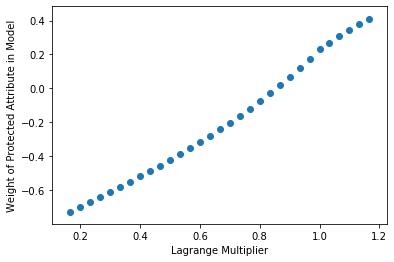

In [16]:
second_sweep_sensitive_feature_weights = [
            x.predictor.coef_[0][1] for x in second_sweep.all_results]
plt.scatter(second_sweep_multipliers, second_sweep_sensitive_feature_weights)
plt.xlabel("Lagrange Multiplier")
plt.ylabel("Weight of Protected Attribute in Model")
plt.show()


We can look at the $\lambda$ and weights placed on each feature in the best model found from this sweep:

In [17]:
lambda_best_second = second_sweep.best_result.lambda_vec[("+", "all", 2)] \
                     -second_sweep.best_result.lambda_vec[("-", "all", 2)]
print("lambda_best =",lambda_best_second)
print("coefficients =",second_sweep.best_result.predictor.coef_)

lambda_best = 0.8333333333333333
coefficients = [[ 2.53725364 -0.02969599]]


And finally, we can obtain a fresh set of predictions from this model. We can see that the threshold is converging on the value 0.2, which was originally specified for just the $a_0$ population:

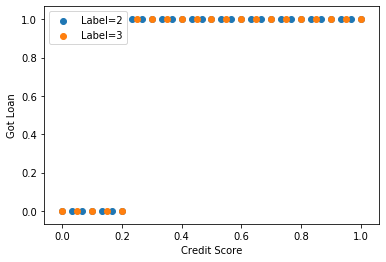

In [18]:
Y_second_predict = second_sweep.predict(X)
plot_data(X, Y_second_predict)